In [1]:
%pylab inline

from pyotf.otf import SheppardPSF, HanserPSF
from pyotf.utils import easy_fft, easy_ifft

Populating the interactive namespace from numpy and matplotlib


In [2]:
# We'll use a 1.27 NA water dipping objective imaging in water
psf_params = dict(
    na=1.27,
    ni=1.33,
    wl=0.561,
    size=64,
    vec_corr="none"
)

# Set the Nyquist sampling rate
nyquist_sampling = psf_params["wl"] / psf_params["na"] / 4

# our oversampling factor, must be odd for easy integration (for peaked symmetrical funtions the kernel must be odd)
oversample_factor = 3

# Over sample to 
psf_params["res"] = nyquist_sampling * 0.99 / oversample_factor
psf_params["size"] *= oversample_factor

In [3]:
psf = SheppardPSF(**psf_params).PSFi

In [4]:
# centered coordinate system.
x = (np.arange(psf_params["size"]) - (psf_params["size"] + 1) // 2) * psf_params["res"]

In [5]:
xx, yy = meshgrid(x, x)

In [6]:
freq = 2 * pi * psf_params["ni"] / psf_params["wl"]
alpha = np.arcsin(psf_params["na"] / psf_params["ni"])
print(freq, np.rad2deg(alpha))
s = np.zeros_like(xx * 1j)
for theta in (-alpha, 0, alpha):
    s += exp(1j*((xx*sin(theta) + yy*cos(theta)) * freq))

14.895965166753742 72.72437394563345


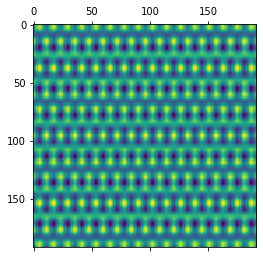

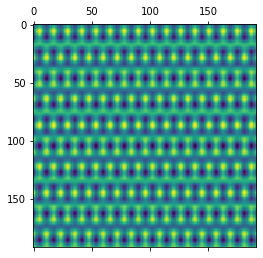

In [7]:
matshow(s.real)
matshow(s.imag)

In [8]:
ss = abs(easy_fft(abs(s)**2))

In [9]:
sss = abs(easy_ifft(ss))

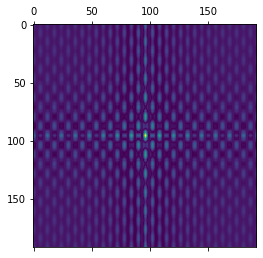

In [10]:
matshow(sss)

In [11]:
from easy_plot import easy_plot

In [14]:
sim_psf = psf * (abs(s)**2)[:, None]

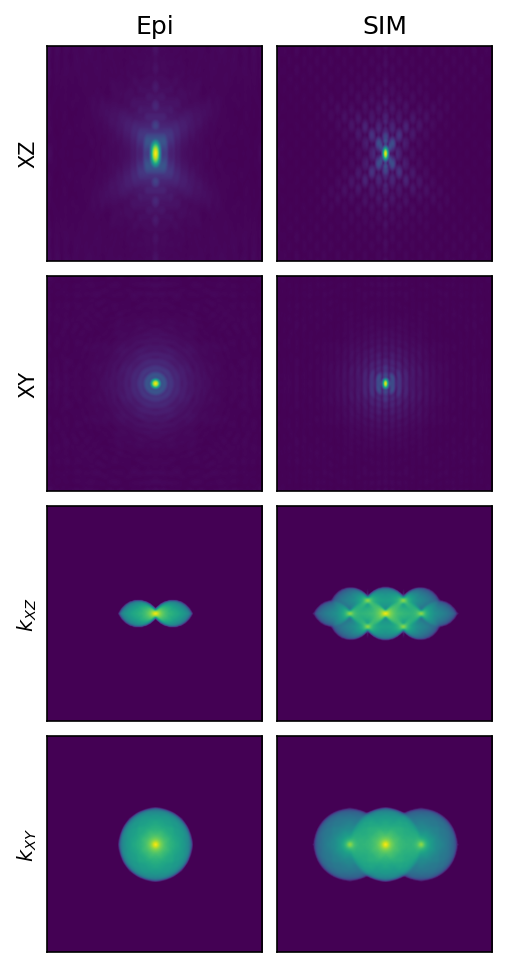

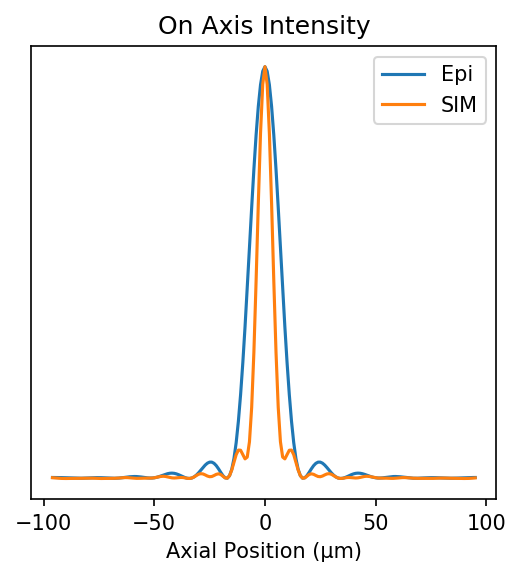

In [15]:
easy_plot((psf, sim_psf), ("Epi", "SIM",), oversample_factor=1, gam=0.5)

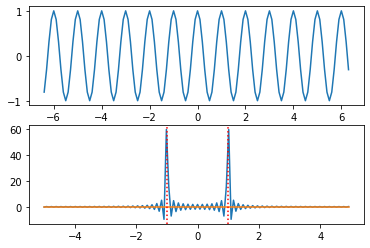

In [13]:
fig, (ax_real, ax_freq) = plt.subplots(2)
dx = 0.1
n = 128
x = (np.arange(n) - (n + 1) // 2) * dx
y = cos(2 * pi * x)
fx = (np.arange(n) - (n + 1) // 2)/ dx / n
fy = easy_fft(y)
ax_real.plot(x, y)
ax_freq.plot(fx, fy.real)
ax_freq.plot(fx, fy.imag)
for i in (-1, 1):
    ax_freq.axvline(i, c="r", ls=":")